<img src="../code/Resources/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Workshop 2: Tutorial on neuronal encoding and behavior</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Thursday, August 26th, 2025</h3> 
<h4 align="center">Day 2</h4> 

#### Add here description about motivation. 

In [1]:
# Standard library
import os  

# Data handling packages
import numpy as np  
import numpy.random as npr  
import pandas as pd 
import pynwb  

# Progress bar utility
from tqdm import tqdm  # Displays a smart progress bar during loops

# Preprocessing
from sklearn.preprocessing import StandardScaler  # Standardizes features (zero mean, unit variance)

# Plotting libraries
import matplotlib.pyplot as plt  
from matplotlib import colors  
import seaborn as sns  

# Pandas display settings
pd.set_option('display.max_columns', None)  # Ensures all columns are shown when printing DataFrames

# Inline plotting for Jupyter Notebooks
%matplotlib inline  


In [2]:
# HMM-related imports from JAX, Dynamax, and TensorFlow Probability
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import GaussianHMM
import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.utils import find_permutation

# Additional HMM variants and plotting utilities from Dynamax
from dynamax.hidden_markov_model import (
    DiagonalGaussianHMM,
    SphericalGaussianHMM,
    SharedCovarianceGaussianHMM
)

from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap


In [3]:
# pick a session_id and get session data
session_id = '742903_2024-10-22'
nwb_path = f'/root/capsule/data/{session_id}/{session_id}.nwb'
session = pynwb.NWBHDF5IO(nwb_path).read()

# access trials table and set interval 
trials = session.trials.to_dataframe()
quiescent_start = trials.stim_start_time.values - 1.5
quiescent_stop = trials.quiescent_stop_time.values

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [4]:
# face expressions, running, pupil

def get_trialwise_values(x, timestamps, start, stop, mean_value=True):
    """
    Extracts trial-wise summary statistics (mean or median) from a time-aligned signal.

    Parameters:
    - x : array-like
        Signal values (e.g., neural data or behavioral measurements).
    - timestamps : array-like
        Time points corresponding to each value in x.
    - start : array-like
        Start times for each trial.
    - stop : array-like
        Stop times for each trial.
    - mean_value : bool, default=True
        If True, compute the mean within each trial window; otherwise compute the median.

    Returns:
    - values : list
        List of mean or median values for each trial window.
    """
    
    if mean_value:
        # Compute mean of x within each [start, stop] window
        return [np.nanmean(x[np.logical_and(s1 <= timestamps, timestamps <= s2)]) 
                for s1, s2 in zip(start, stop)]
    else:
        # Compute median of x within each [start, stop] window
        return [np.nanmedian(x[np.logical_and(s1 <= timestamps, timestamps <= s2)]) 
                for s1, s2 in zip(start, stop)]

behavior_data = {}

# facial expressions: 
def get_facial_feature(part_name, facial_features_df):
    confidence = facial_features_df[f'{part_name}_likelihood']
    temporal_norm = facial_features_df[f'{part_name}_temporal_norm']
    x = facial_features_df[f'{part_name}_x']
    y = 492 - facial_features_df[f'{part_name}_y']
    xy = np.sqrt(x**2 + y**2)
    xy[(confidence < 0.98) | (temporal_norm > np.nanmean(temporal_norm) + 3 * np.nanstd(temporal_norm))] = np.nan
    xy = pd.Series(xy).interpolate(limit_direction='both').to_numpy() 
    return xy


facial_features_df = session.processing['behavior']['lp_side_camera'][:]
feature_timestamps = facial_features_df['timestamps'].values.astype('float')
map_names = {'ears': 'ear_base_l', 'jaw': 'jaw', 'nose': 'nose_tip', 'whisker_pad': 'whisker_pad_l_side'}

ear = get_facial_feature('ear_base_l', facial_features_df)
behavior_data['ear_median_position'] = get_trialwise_values(ear, feature_timestamps, quiescent_start, quiescent_stop)

jaw = get_facial_feature('jaw', facial_features_df)
behavior_data['jaw_median_position'] =  get_trialwise_values(jaw, feature_timestamps, quiescent_start, quiescent_stop)

nose = get_facial_feature('nose_tip', facial_features_df)
behavior_data['nose_median_position'] = get_trialwise_values(nose, feature_timestamps, quiescent_start, quiescent_stop)

whisker_pad =  get_facial_feature('whisker_pad_l_side', facial_features_df)
behavior_data['whisker_median_position'] = get_trialwise_values(whisker_pad, feature_timestamps,  quiescent_start, quiescent_stop)

# running
running_data = session.processing['behavior']['running_speed']
running_timestamps = running_data.timestamps[:]
running_speed = running_data.data[:]
behavior_data['mean_speed'] = get_trialwise_values(running_speed, running_timestamps, quiescent_start, quiescent_stop)


# pupil
pupil_data = session.processing['behavior']['eye_tracking']
pupil_timestamps = pupil_data.timestamps[:]
pupil_area = pupil_data.pupil_area[:]
behavior_data['mean_pupil_area'] = get_trialwise_values(pupil_area, pupil_timestamps, quiescent_start, quiescent_stop)


# lick counts - exclude when analyzing quiescent interval! 
lick_data = session.processing['behavior']['licks']
lick_times = lick_data.timestamps[:]
lick_duration = lick_data.data[:]
lick_duration_threshold = 0.5
lick_times = lick_times[lick_duration < lick_duration_threshold]
in_bin = (lick_times[:, None] >= quiescent_start) & (lick_times[:, None] < quiescent_stop)
lick_counts = np.any(in_bin, axis=0).astype(int)

behavior_data = pd.DataFrame(behavior_data)

# response rates
vis1_response_rate = trials[(trials["stim_name"] == 'vis1')].is_hit.rolling(5).mean()
vis2_response_rate = trials[(trials["stim_name"] == 'vis2')].is_hit.rolling(5).mean()
sound1_response_rate = trials[(trials["stim_name"] == 'sound1')].is_hit.rolling(5).mean()
sound2_response_rate = trials[(trials["stim_name"] == 'sound2')].is_hit.rolling(5).mean()

task_data = pd.DataFrame({
    'vis1_reponse_rate': vis1_response_rate, 
    'vis2_reponse_rate': vis2_response_rate,
    'sound1_reponse_rate': sound1_response_rate,
    'sound2_reponse_rate': sound2_response_rate,
})

In [5]:
# For this model, it's important that the data is converted into a *JAX* array
observations = jnp.array( behavior_data.values)

# First scale the dimensions of the data to be normalized
scaler = StandardScaler()      
observations = scaler.fit_transform(observations)

# Split the data into equal length batches for cross-validation
n_batches = 6
n_steps = num_trials - (num_trials % n_batches)
batched_observations = observations[:n_steps, :].reshape(n_batches, -1, observations.shape[1])
batch_size = batched_observations.shape[1]

NameError: name 'num_trials' is not defined

In [ ]:

# Define empty lists that we'll populate below
avg_test_log_probs = []
all_test_log_probs = []
std_test_log_probs = []
similarity_of_states_across_batches = []

num_trials, num_dimensions = observations.shape

key = jr.PRNGKey(0)

# Run a loop to fit the data to a range of states
for num_states in range(1, 8):
    print(f"\n{'='*40}\nTraining model with {num_states} state(s)\n{'='*40}")

    test_log_probs = []
    
    predicted_states = np.zeros([num_trials, n_batches], dtype = int)
    
    for batch in range(n_batches):
        # Extract all but this batch for training
        train_observations = np.concatenate([batched_observations[:batch], batched_observations[batch+1:]])#.reshape((n_batches - 1)*batch_size, -1)
        flat_train_observations = train_observations.reshape((n_batches - 1) * batch_size, -1)
        if num_states == 1:
            train_mean = jnp.mean(flat_train_observations, axis=0).reshape([1,num_dimensions])
            train_cov = jnp.cov(flat_train_observations.T)
            test_data = jnp.array(batched_observations[batch])    #scaler.transform(jnp.array(batched_observations[batch]))
            test_lp = tfd.MultivariateNormalFullCovariance(train_mean, train_cov).log_prob(batched_observations[batch]).sum()
        else:
            # Make an HMM
            hmm = GaussianHMM(num_states, num_dimensions, transition_matrix_stickiness=10)
            params, param_props = hmm.initialize(key=key, method="kmeans", emissions=jnp.array(train_observations))

            # Fit the model
            params, lps = hmm.fit_em(params, param_props, jnp.array(train_observations), num_iters=500)
            
            #extract predicted states
            predicted_states[:,batch] = hmm.most_likely_states(params, observations)

            # Evaluate the log probability on held out data
            test_lp = hmm.marginal_log_prob(params, jnp.array(batched_observations[batch]))
        test_log_probs.append(test_lp)

    # Calculate the similarity of each set of predicted states
    if batch != 1:
        distance_between_batches = []
        for i in range(n_batches):
            for j in range(i-1):
                bestpermutation = find_permutation(predicted_states[:,i], predicted_states[:,j])
                distance_between_batches.append(np.sum(jnp.take(bestpermutation, predicted_states[:,i]) == predicted_states[:,j])/observations.shape[0])
        similarity_of_states_across_batches.append(np.mean(distance_between_batches))
    else:
        similarity_of_states_across_batches.append(1)
        
    # Store the average test log prob
    all_test_log_probs.append(test_log_probs)
    avg_test_log_probs.append(np.nanmean(test_log_probs))
    std_test_log_probs.append(np.nanstd(test_log_probs))    


Training model with 1 state(s)

Training model with 2 state(s)



Training model with 3 state(s)



Training model with 4 state(s)



Training model with 5 state(s)



Training model with 6 state(s)



Training model with 7 state(s)


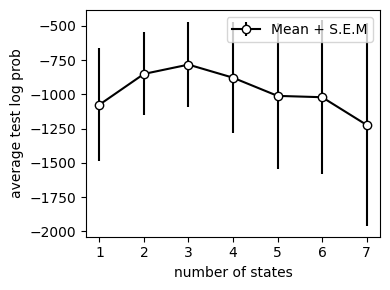

In [ ]:
plt.figure(figsize = (4, 3))
plt.errorbar(np.arange(1, 8), avg_test_log_probs, yerr = np.array(std_test_log_probs)/np.sqrt(n_batches), mfc = 'w', color = 'k', marker = 'o')

# If you like, you can plot up each of the log_probs from the session.
#for k, test_log_probs in zip(np.arange(1, 8), all_test_log_probs):
#    plt.plot(k * np.ones(n_batches), test_log_probs, 'r.')

plt.legend(['Mean + S.E.M'])
plt.xlabel("number of states")
plt.ylabel("average test log prob")
plt.tight_layout()

In [ ]:
best_num_states = np.arange(1, 8)[np.nanargmax(avg_test_log_probs)]

In [ ]:
key = jr.PRNGKey(0)

number_of_states = best_num_states
final_hmm = GaussianHMM(number_of_states, num_dimensions, transition_matrix_stickiness=100.)
params, param_props = final_hmm.initialize(key=key, method="kmeans", emissions=jnp.array(observations))
params, lps = final_hmm.fit_em(params, param_props, jnp.array(observations), num_iters=500)


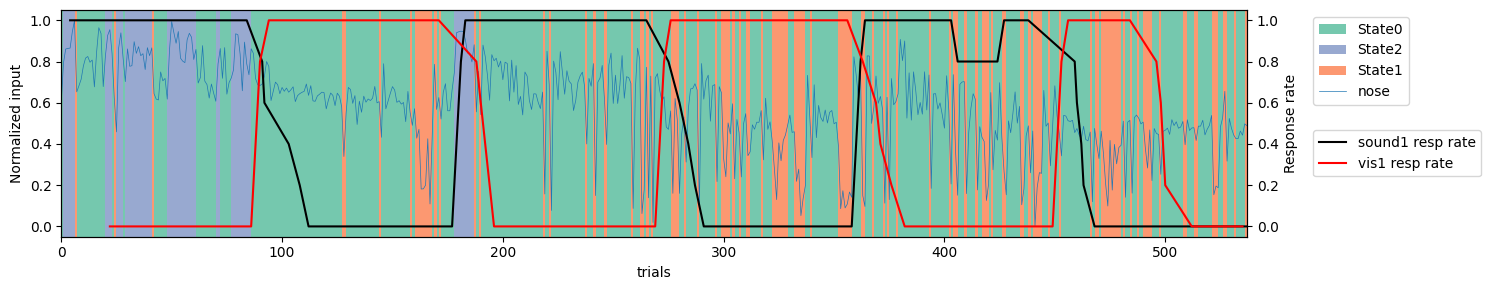

In [ ]:
go_trials = np.arange(len(trials))

def minmax(x):
    # Function to normalize the data for easy visualization
    return (x - np.min(x))/(np.max(x) - np.min(x)) 

# Find the most likely discrete states given the learned model parameters
most_likely_states = final_hmm.most_likely_states(params, observations)

# Overlay the precision and recall curves on top of the inferred states
fig, ax = plt.subplots(figsize=(15, 3))
cmap =sns.color_palette("Set2", best_num_states)
bounds=np.arange(-0.5, best_num_states, 0.5)

# Define state boundaries 
states = most_likely_states
switch_trials = np.where(np.diff(states))[0]
switch_trials = np.concatenate(([0], switch_trials, [len(go_trials)-1]))

# Plot the states 
for i, trial in enumerate(switch_trials[:-1]):
    for state_no in range(best_num_states):
        if states[trial+1] == state_no: 
            ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], 
                       facecolor= cmap[state_no], alpha=0.9, label = 'State' + str(state_no))

ax.plot(go_trials, minmax(behavior_data['nose_median_position']), color = 'tab:blue', label="nose", lw = 0.5)
# Overlay behavioral variables 
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.05, 1), fontsize = 10)

ax2 = ax.twinx()
ax2.plot(sound1_response_rate, color = 'k', label = 'sound1 resp rate')
ax2.plot(vis1_response_rate, color = 'r', label = 'vis1 resp rate')
ax2.set_ylabel('Response rate')
ax2.legend( bbox_to_anchor = (1.05, 0.5))


# Formatting 
ax.set_xlim(go_trials[0], go_trials[-1])
ax.set_ylabel("Normalized input")
ax.set_xlabel("trials")
plt.tight_layout()

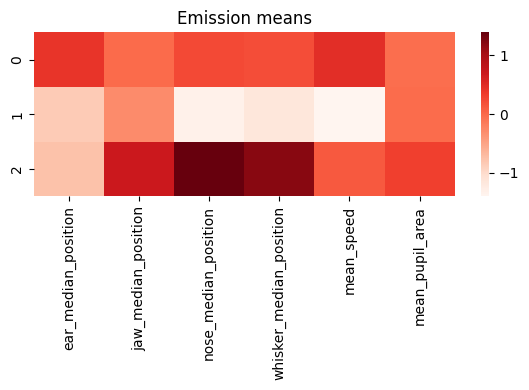

In [ ]:
plt.figure(figsize = (5.8, 4))
sns.heatmap(params.emissions.means, xticklabels = behavior_data.keys(), yticklabels= np.arange(number_of_states), cmap = 'Reds')
plt.title('Emission means')
plt.tight_layout()